In [1]:
from google import genai
from google.genai import types
from IPython.display import Markdown

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [3]:
client = genai.Client(api_key = GEMINI_API_KEY)

response = client.models.generate_content(
    model = "gemini-2.0-flash",
    contents = "hola como estas"
)

print(response.text)

¡Hola! Estoy bien, gracias por preguntar. ¿Y tú, cómo estás? ¿En qué puedo ayudarte hoy?



In [4]:
for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [5]:
DOCUMENT1 = "Operating the Climate Control System  Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car. To operate the climate control system, use the buttons and knobs located on the center console.  Temperature: The temperature knob controls the temperature inside the car. Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature. Airflow: The airflow knob controls the amount of airflow inside the car. Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow. Fan speed: The fan speed knob controls the speed of the fan. Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed. Mode: The mode button allows you to select the desired mode. The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level. Cool: The car will blow cool air into the car. Heat: The car will blow warm air into the car. Defrost: The car will blow warm air onto the windshield to defrost it."
DOCUMENT2 = 'Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the "Navigation" icon to get directions to your destination or touch the "Music" icon to play your favorite songs.'
DOCUMENT3 = "Shifting Gears Your Googlecar has an automatic transmission. To shift gears, simply move the shift lever to the desired position.  Park: This position is used when you are parked. The wheels are locked and the car cannot move. Reverse: This position is used to back up. Neutral: This position is used when you are stopped at a light or in traffic. The car is not in gear and will not move unless you press the gas pedal. Drive: This position is used to drive forward. Low: This position is used for driving in snow or other slippery conditions."

documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3]

In [6]:
# Usage of the __call__ make the instance of the class behave like an function 


#  class RoastBot:
#      def __call__(self, name):
#          return f"{name}, you code like you just discovered Stack Overflow yesterday."

#  bot = RoastBot()
#  print(bot("Apoorv"))  # ← LOOK AT THAT!


In [7]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry
from google.genai import types

# Helper to retry when per minute quota is reached 
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

class GeminiEmbeddingFunction(EmbeddingFunction):
    document_mode = True
    @retry.Retry(predicate=is_retriable)
    def __call__(self, input:Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model = "models/text-embedding-004",
            contents = input,
            config = types.EmbedContentConfig(
                task_type = embedding_task
            )
        )   
        return [e.values for e in response.embeddings]

In [12]:
import chromadb

DB_NAME = "googlecardb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()

db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(
    documents = documents,
    ids = [str(i) for i in range(len(documents))],
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11188\2257871503.py:5: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  embed_fn = GeminiEmbeddingFunction()


In [13]:
db.count()  # Check the number of documents in the collection

3

In [16]:
embed_fn.document_mode = False

query = 'How do you play music in the car?'

result = db.query(query_texts=[query], n_results=1)
[all_passages] = result['documents']

Markdown(all_passages[0])

Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the "Navigation" icon to get directions to your destination or touch the "Music" icon to play your favorite songs.

In [17]:
query_oneline = query.replace("\n", " ")

# This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
prompt = f"""You are a helpful and informative bot that answers questions using text from the reference passage included below. 
Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. 
However, you are talking to a non-technical audience, so be sure to break down complicated concepts and 
strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.

QUESTION: {query_oneline}
"""

# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", " ")
    prompt += f"PASSAGE: {passage_oneline}\n"

print(prompt)

You are a helpful and informative bot that answers questions using text from the reference passage included below. 
Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. 
However, you are talking to a non-technical audience, so be sure to break down complicated concepts and 
strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.

QUESTION: How do you play music in the car?
PASSAGE: Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the "Navigation" icon to get directions to your destination or touch the "Music" icon to play your favorite songs.



In [18]:
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)

Markdown(answer.text)

To listen to music in your Googlecar, simply touch the "Music" icon on the large touchscreen display. This will allow you to play your favorite songs and enjoy entertainment while driving.


## Embeddings and similarity scores

In [19]:
from google import genai
from google.genai import types

In [23]:
from dotenv import load_dotenv
import os

load_dotenv()
GEMINI_API_KEY_API_KEY = os.getenv("GEMINI_API_KEY")

In [24]:
client = genai.Client(api_key=GEMINI_API_KEY)

for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [ ]:
texts = [
    'The quick brown fox jumps over the lazy dog.',
    'The quick rbown fox jumps over the lazy dog.',
    'teh fast fox jumps over the slow woofer.',
    'a quick brown fox jmps over lazy dog.',
    'brown fox jumping over dog',
    'fox > dog',
    # Alternative pangram for comparison:
    'The five boxing wizards jump quickly.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',
]


response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))

In [28]:
# Helper function to reduce the limit of the sentences

def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

<Axes: >

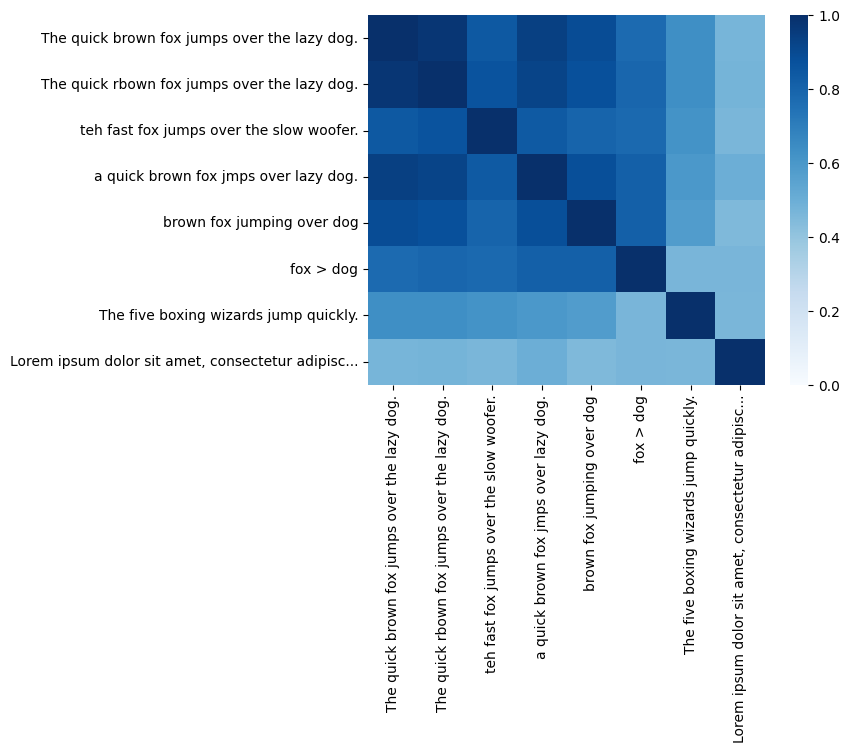

In [31]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame([e.values for e in response.embeddings], index = truncated_texts)

sim = df @ df.T

sns.heatmap(sim, vmin = 0, vmax = 1, cmap = 'Blues')

In [ ]:
# THis is the similarity of the senteces to the current sentence.

sim['The quick brown fox jumps over the lazy dog.'].sort_values(ascending=False)

The quick brown fox jumps over the lazy dog.          0.999999
The quick rbown fox jumps over the lazy dog.          0.975623
a quick brown fox jmps over lazy dog.                 0.939730
brown fox jumping over dog                            0.894507
teh fast fox jumps over the slow woofer.              0.842152
fox > dog                                             0.776455
The five boxing wizards jump quickly.                 0.635346
Lorem ipsum dolor sit amet, consectetur adipisc...    0.472174
Name: The quick brown fox jumps over the lazy dog., dtype: float64

## Classifying embeddings with Keras

In [1]:
from google import genai
from google.genai import types

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [3]:
client = genai.Client(api_key=GEMINI_API_KEY)

In [4]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [7]:
import email
import re
import pandas as pd

def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate each entry to 5,000 characters
    text = text[:5000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df


In [8]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [11]:
# df is the dataframe , num_samples is the number of samples we want, classes_to_keep is the classes we want to keep

def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each label
    df = (
        df.groupby('Label')[df.columns].apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
          )
    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")
    df["Encoded Label"] = df["Class Name"].cat.codes

    return df

In [12]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25

# Class name should contain 'sci' to keep science categories.
# Try different labels from the data - see newsgroups_train.target_names
CLASSES_TO_KEEP = "sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [13]:
df_train.value_counts("Class Name")

Class Name
sci.crypt          100
sci.electronics    100
sci.med            100
sci.space          100
Name: count, dtype: int64

In [14]:
df_test.value_counts("Class Name")

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
Name: count, dtype: int64

In [ ]:
from google.api_core import retry
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

# Add tqdm to Pandas...
tqdmr.pandas()

# ...But suppress the experimental warning.
warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)

# Define a helper to retry when per-minute quota is reached.

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

# THIs retry code block tries the function again until the timeout if the error matches the predicate i.e is_retrible
@retry.Retry(predicate=is_retriable, timeout=300.0)
def embed_fn(text: str) -> list[float]:
    response = client.models.embed_content(
            model = "models/text-embedding-004",
            contents = text,
            config = types.EmbedContentConfig(
                task_type = "classification"
            )       
        )
    return response.embeddings[0].values

def create_embeddings(df):
    df['Embeddings'] = df["Text"].progress_apply(embed_fn)
    return df

In [19]:
df_train = create_embeddings(df_train)
df_test = create_embeddings(df_test)

Output()

Output()

In [21]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,Re: text of White House announcement and Q&As ...,11,sci.crypt,0,"[0.0002631662, 0.035350192, -0.05077413, 0.012..."
1101,Re: text of White House announcement and Q&As ...,11,sci.crypt,0,"[-0.02071678, 0.016975796, -0.053583395, 0.001..."
1102,Re: text of White House announcement and Q&As ...,11,sci.crypt,0,"[-0.011968107, 0.03321668, -0.03567512, 0.0351..."
1103,Re: Secret algorithm [Re: Clipper Chip and cry...,11,sci.crypt,0,"[-0.00510181, 0.020456951, -0.022433043, 0.057..."
1104,Re: Secret algorithm [Re: Clipper Chip and cry...,11,sci.crypt,0,"[0.011895708, 0.03948156, -0.03459842, 0.03704..."


In [35]:
import tensorflow.keras as tk
from tensorflow.keras import layers


# Function defines the custom model for the classification task.
def build_classification_model(input_size: int, num_classes: int) -> tk.Model:
    return tk.Sequential(
        [
            layers.Input([input_size], name = "embedding_input"),
            layers.Dense(input_size, activation="relu", name = 'hidden'),
            layers.Dense(num_classes, activation="softmax", name = 'output_probabs')
        ]
    )

In [36]:
embedding_size = len(df_train["Embeddings"].iloc[0])

classifier = build_classification_model(embedding_size, len(df_train["Class Name"].unique()))

classifier.summary()

classifier.compile(
    loss=tk.losses.SparseCategoricalCrossentropy(),
    optimizer=tk.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probabs (Dense)          │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
import numpy as np

NUM_EPOCHS = 20
BATCH_SIZE = 32

y_train = df_train["Encoded Label"]
x_train = np.stack(df_train["Embeddings"])
y_val = df_test["Encoded Label"]
x_val = np.stack(df_test["Embeddings"])

# Specify that it's OK to stop early if accuracy stabilises.
early_stop = tk.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Train the model for the desired number of epochs.
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2875 - loss: 1.3720 - val_accuracy: 0.4000 - val_loss: 1.2870
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5873 - loss: 1.2345 - val_accuracy: 0.8900 - val_loss: 1.1452
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8679 - loss: 1.0578 - val_accuracy: 0.8700 - val_loss: 0.9929
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8515 - loss: 0.8697 - val_accuracy: 0.8600 - val_loss: 0.8439
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9220 - loss: 0.7091 - val_accuracy: 0.9100 - val_loss: 0.6752
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9443 - loss: 0.5202 - val_accuracy: 0.9400 - val_loss: 0.5620
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9572 - loss: 0.3965 - val_accuracy: 0.9300 - val_loss: 0.4945
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9309 - loss: 0.3524 - val_accuracy: 0.9300 - val_loss

In [41]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,Re: text of White House announcement and Q&As ...,11,sci.crypt,0,"[0.0002631662, 0.035350192, -0.05077413, 0.012..."
1101,Re: text of White House announcement and Q&As ...,11,sci.crypt,0,"[-0.02071678, 0.016975796, -0.053583395, 0.001..."
1102,Re: text of White House announcement and Q&As ...,11,sci.crypt,0,"[-0.011968107, 0.03321668, -0.03567512, 0.0351..."
1103,Re: Secret algorithm [Re: Clipper Chip and cry...,11,sci.crypt,0,"[-0.00510181, 0.020456951, -0.022433043, 0.057..."
1104,Re: Secret algorithm [Re: Clipper Chip and cry...,11,sci.crypt,0,"[0.011895708, 0.03948156, -0.03459842, 0.03704..."


In [39]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9262 - loss: 0.1899 


{'accuracy': 0.9300000071525574, 'loss': 0.1924070119857788}

In [42]:
def make_prediction(text: str) -> list[float]:
    embedded = embed_fn(text)
    inp = np.array([embedded])
    [result] = classifier.predict(inp)
    return result
    

In [43]:
new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

result = make_prediction(new_text)

for idx, category in enumerate(df_test["Class Name"].cat.categories):
    print(f"{category}: {result[idx] * 100:0.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
sci.crypt: 0.06%
sci.electronics: 0.64%
sci.med: 0.06%
sci.space: 99.24%
